In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

tf.__version__

2025-06-28 02:47:01.750272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-28 02:47:01.750383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-28 02:47:01.882840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

## Configurations

In [2]:
INFERENCE_DEVICE = 'GPU:0' if len(tf.config.list_physical_devices('GPU')) else 'CPU:0'

################################
###### Configurations #########
##############################
seed = 999
SEED = seed
USE_DETERMINISTIC = True
K_FOLD_INDEX = 4
oversampling = 0 # How many times are we gonna over sample

## Model Configurations
MODEL_NAME=f"MobileNetV3Small_KF{K_FOLD_INDEX+1}.keras"
IMG_SIZE=(224,224,3)

### LRCAM Config ---
LRSA_NUM_POOL_CHANNELS = 16

## Training Configurations
TRAIN_BATCH_SIZE=32
EPOCHS = 300
ES_PATIENCE = 16 ## Patience Epoch for Early Stopping
ES_MONITOR = 'val_loss'
LR_REDUCTION_FACTOR = 0.8 ## for ReduceLROnPlateau Callback
LR_REDUCTION_PATIENCE = 3 ## Patience for LR Reduction
LR_REDUCTION_MONITOR = 'val_loss'

##### FineTuning Part
INIT_LR1 = 2e-4 ## Initial Learning Rate (AdamW) 
W_DECAY1 = 5e-2 ## Weight Decay
MIN_LR1 = 1e-7 ## Minimum Learning Rate for ReduceLROnPlateau Callback
##
USE_WARMUP = False
WARMUP_EPOCHS = 5
WARMUP_INIT_LR = INIT_LR1 / WARMUP_EPOCHS
WARMUP_MAX_LR = INIT_LR1
WARMUP_INCREMENT_RATE = 0.3

##### Base Model Freezing Part
INIT_LR2 = 2e-6 # Initial Learning Rate for optimizer (AdamW)
W_DECAY2 = 5e-4 ## Weight Decay for optimizer
MIN_LR2 = 1e-9 # Minimum Learning Rate for ReduceLROnPlateau

#### -- Optimizer
USE_ADAMW = '2.15' in tf.__version__
#########################################
isKaggle = 'kaggle' in os.getcwd()

if isKaggle:
    DATASET_PATH = "/kaggle/input/deepweeds"
    IMAGE_DATASET_PATH = "/kaggle/input/deepweeds/images" ## For Kaggle
    DATASET_OUTPUT_PATH = "/kaggle/working/deepweeds_9c" ## For Kaggle
else:
    try:
        DATASET_PATH = reganmaharjan_deepweeds_path
        DATASET_OUTPUT_PATH = '/content/dataset_9c' ## For GoogleColab
        IMAGE_DATASET_PATH = reganmaharjan_deepweeds_path + '/images' ## For GoogleColab
    except:
        DATASET_PATH = ''
        IMAGE_DATASET_PATH = '' ## Assign The Image Path
        DATASET_OUTPUT_PATH = '' ## Assign The path where the Images are to ogranized for Data Generator from Directory


isTPU = False
fixDatasetBatch = False ## if True: duplicates files randomly such that each batch contains same no.of files - Required when isTPU=True.

In [3]:
print("Tensorflow version " + tf.__version__)
if tf.config.list_logical_devices('TPU'):
    if isKaggle:
        # On TPU VMs use this line instead:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")  ## if kaggle
    else:        
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver() ## if colab

    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

    #---------
    strategy = tf.distribute.TPUStrategy(resolver)
    print('TPU available')
    isTPU = True
else: ### If GPU or CPU
    if tf.config.list_logical_devices('GPU'): 
        print('GPU available')
    else:
        print("Only CPU available")
       
    # For testing without a TPU use this line instead: 
    # strategy = tf.distribute.OneDeviceStrategy("/cpu:0")
    strategy = tf.distribute.MirroredStrategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)
if isTPU:
    USE_ADAMW = False
    print("Use ADAM with TPU")

Tensorflow version 2.15.0
GPU available
REPLICAS:  1


In [4]:
def seedEverything(seed=42, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    tf.keras.utils.set_random_seed(seed)
    
    if deterministic:
        tf.config.experimental.enable_op_determinism()
        
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(SEED, USE_DETERMINISTIC)
tf.config.set_soft_device_placement(True)

In [5]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [6]:
try:
    data_info = pd.read_csv(f"{DATASET_PATH}/labels.csv") ## For Kaggle
except:
    data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [7]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [8]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [9]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [10]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = K_FOLD_INDEX # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 5 out of 5 folds
-------------------------------------------------



In [11]:
## Using Folds Used in The DeepWeeds Paper
try:
    train_data = pd.read_csv(f'{DATASET_PATH}/train_subset{K_FOLD_INDEX}.csv')
    valid_data = pd.read_csv(f'{DATASET_PATH}/val_subset{K_FOLD_INDEX}.csv')
    test_data = pd.read_csv(f'{DATASET_PATH}/test_subset{K_FOLD_INDEX}.csv')

except:
    train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
    valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
    test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab

train_data.rename(columns={"Label":"label"}, inplace=True)
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  606  645  610  5464 	Total: (10508, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  205  213  202  215  203  1821 	Total: (3503, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  204  212  201  214  203  1821 	Total: (3498, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [12]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0, oversampling_labels=[]):
    indices=[]
    if fixDatasetBatch or isTPU:
        batch = TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync
        size = data_info.shape[0]
        remainder = size % batch
        residue = batch - remainder
        rng = np.arange(size)
        np.random.shuffle(rng)
        indices = rng[:residue]
        
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)
            elif index in indices:
                sample_filename = os.path.join(target_path, f"last_batch_fix_{index}-"+filename)
                shutil.copy(source, sample_filename)
                
            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import math

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = [0.0 if math.isnan(v) else v for v in history['accuracy']]
    val_acc = [0.0 if math.isnan(v) else v for v in history['val_accuracy']]
    loss = [0.0 if math.isnan(v) else v for v in history['loss']]
    val_loss = [0.0 if math.isnan(v) else v for v in history['val_loss']]
    
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [14]:
if oversampling:
    print("Oversampling training set",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

input_dir = IMAGE_DATASET_PATH
base_dir = DATASET_OUTPUT_PATH

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=TRAIN_BATCH_SIZE,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

with strategy.scope(): 
    if isTPU:  
        TRAIN_BATCH_SIZE = 16
        train_generator = train_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        validation_generator = validation_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        test_generator = test_generator.rebatch(TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync, drop_remainder=True)
        
    train_generator = train_generator.prefetch(tf.data.AUTOTUNE)
    validation_generator = validation_generator.prefetch(tf.data.AUTOTUNE)
    test_generator = test_generator.prefetch(tf.data.AUTOTUNE)     

Found 10508 files belonging to 9 classes.
Found 3503 files belonging to 9 classes.
Found 3498 files belonging to 9 classes.


# Sample Images

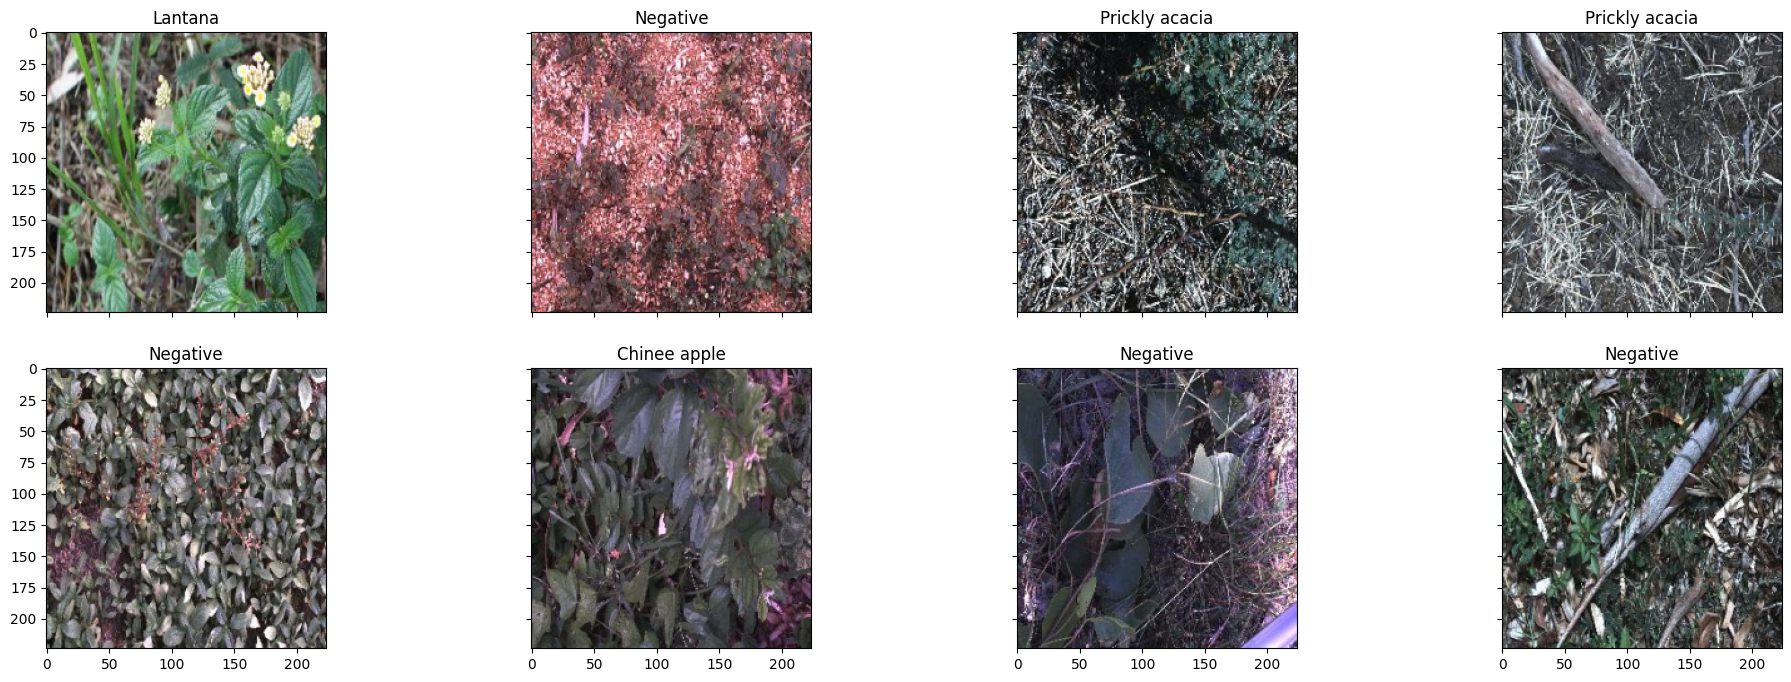

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax


def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run on deterministic mode
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, fill_mode='wrap', name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, fill_mode='wrap', seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, fill_mode='wrap', name='RR_Zoom'),
        layers.GaussianNoise(0.01, seed=SEED, name='RR_GNoise'),
        # layers.GaussianDropout(0.01, seed=seed, name='RR_GDrop'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def hard_sigmoid(x):
    relu6 = layers.ReLU(max_value=6)
    return relu6(x + 3) / 6
    
def hard_swish(x):
    return x * hard_sigmoid(x)

def MobilenetV3Base(img_size):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('conv' in mobilenet.layers[i].name):
            pi1 = i
            break
    
    FCLayer = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-FCLayer")
    
    return base_model , FCLayer

def buildModel(IMG_SIZE, fusion_type='average', cbam_order='normal', skip_preprocess=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, FCLayer = MobilenetV3Base(IMG_SIZE)
    base_model.trainable = True
    FCLayer.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    if not skip_preprocess:
        x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
        x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)
    
        x = augment(seed)(x)
    else:
        x = inputs
    
    x = base_model(x, training=True)
    x = layers.Dropout(0.3, seed=seed)(x) 
    
    x = layers.GlobalAveragePooling2D(keepdims=False)(x)
    # x = layers.Flatten()(x)
    # x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)
    model_name = "DeepWeeds-" + base_model.name
    
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [19]:
with strategy.scope():
    model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Base Model: MobilenetV3small_base_
228
Model: "DeepWeeds-MobilenetV3small_base_"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 PP_Rescale_down (Rescaling  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 PP_Resize (Resizing)        (None, 224, 224, 3)       0         
                                                                 
 augment_pipeline (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 MobilenetV3small_base_ (Fu  (None, 7, 7, 576)         939120 

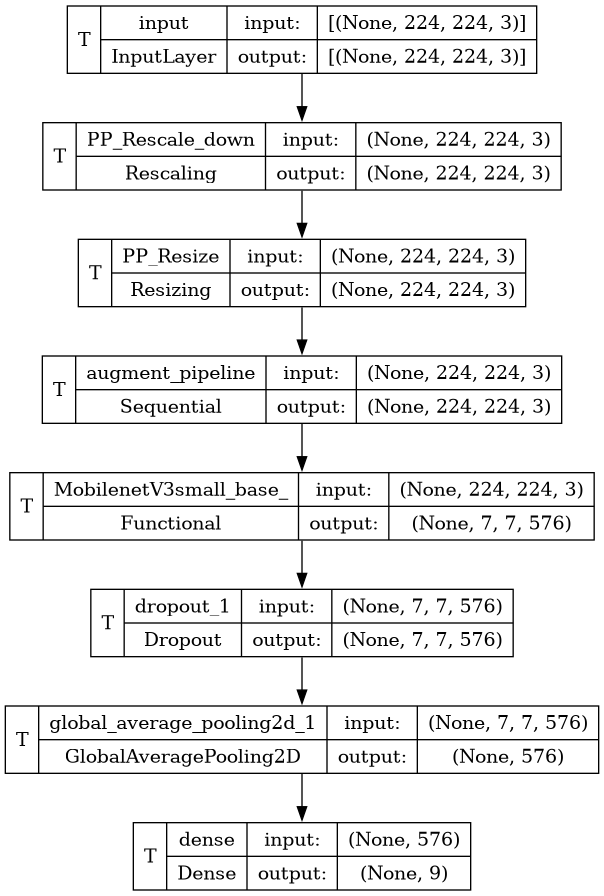

In [20]:
tf.keras.utils.plot_model(model, show_trainable=True, show_layer_names=True, show_shapes=True)

# Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import Adam, AdamW

checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor=ES_MONITOR)
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1, clipnorm=10.0) if not USE_ADAMW else AdamW(learning_rate=(WARMUP_INIT_LR if USE_WARMUP else INIT_LR1),  weight_decay=W_DECAY1)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=ES_MONITOR, patience=ES_PATIENCE, verbose=1, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=LR_REDUCTION_FACTOR, patience=LR_REDUCTION_PATIENCE, verbose=1, min_lr=MIN_LR1)

    def createWarmUpScheduler(epochs=5, inc_rate=0.5, init_lr=2e-6, final_lr=2e-5):
        def scheduler(e, lr):
            if e < epochs:
                new_lr =  lr + (lr * inc_rate)
                return new_lr if new_lr < final_lr else final_lr
            elif e == epochs:
                return final_lr
            else:
                return lr

        return scheduler
        
    warmup = keras.callbacks.LearningRateScheduler(createWarmUpScheduler(WARMUP_EPOCHS, WARMUP_INCREMENT_RATE, WARMUP_INIT_LR, INIT_LR1))

    callbacks = [checkpoint, early_stopping, reduce_lr] + ([warmup] if USE_WARMUP else [])
    print(len(callbacks))

print(model.optimizer.get_config())

3
{'name': 'AdamW', 'weight_decay': 0.05, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.0002, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-28 02:49:35.676262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1751078980.916028      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 53s 77ms/step - loss: 0.1838 - accuracy: 0.6079 - val_loss: 0.1045 - val_accuracy: 0.7222 - lr: 2.0000e-04
Epoch 2/300
329/329 [==============================] - 23s 69ms/step - loss: 0.0947 - accuracy: 0.7509 - val_loss: 0.0720 - val_accuracy: 0.7999 - lr: 2.0000e-04
Epoch 3/300
329/329 [==============================] - 23s 69ms/step - loss: 0.0722 - accuracy: 0.8021 - val_loss: 0.0592 - val_accuracy: 0.8319 - lr: 2.0000e-04
Epoch 4/300
329/329 [==============================] - 23s 70ms/step - loss: 0.0607 - accuracy: 0.8279 - val_loss: 0.0512 - val_accuracy: 0.8547 - lr: 2.0000e-04
Epoch 5/300
329/329 [==============================] - 23s 68ms/step - loss: 0.0546 - accuracy: 0.8451 - val_loss: 0.0453 - val_accuracy: 0.8667 - lr: 2.0000e-04
Epoch 6/300
329/329 [==============================] - 23s 69ms/step - loss: 0.0467 - accuracy: 0.8633 - val_loss: 0.0434 - val_accuracy: 0.8661 - lr: 2.0000e-04
Epoch 7/300
329/329 [===================

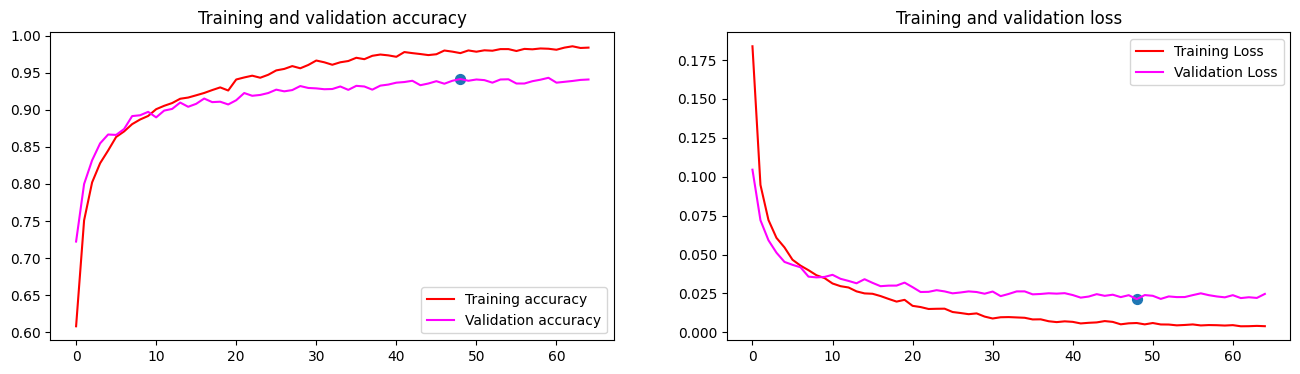

CPU times: user 49min 48s, sys: 3min 46s, total: 53min 35s
Wall time: 24min 42s


In [22]:
%%time
# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=callbacks,
    )

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1

Train Set Statistics
model.evaluate
329/329 [==============================] - 8s 24ms/step - loss: 0.0027 - accuracy: 0.9895
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.98946   0.97189   0.98060       676
       Lantana    0.99051   0.98119   0.98583       638
   Parkinsonia    0.99029   0.98869   0.98949       619
    Parthenium    0.99667   0.97716   0.98682       613
Prickly acacia    0.97816   0.98430   0.98122       637
   Rubber vine    0.98852   0.99505   0.99178       606
     Siam weed    0.98607   0.98760   0.98683       645
    Snake weed    0.96166   0.98689   0.97411       610
      Negative    0.99159   0.99268   0.99213      5464

      accuracy                        0.98848     10508
     macro avg    0.98588   0.98505   0.98542     10508
  weighted avg    0.98854   0.98848   0.98849     10508


                False Positive Rate  Accuracy
Chinee apple               0.000712  0.971893
Lantana                    0.000608  0.981191
Parkinsonia                0.000607  0.988691
Parthenium                 0.000202  0.977162
Prickly acacia    

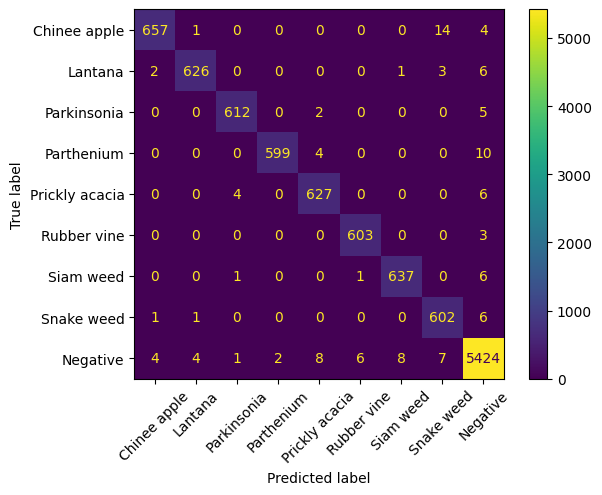


Validation Set Statistics
model.evaluate
110/110 [==============================] - 3s 21ms/step - loss: 0.0226 - accuracy: 0.9369
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.89320   0.81778   0.85383       225
       Lantana    0.90094   0.89671   0.89882       213
   Parkinsonia    0.97596   0.98544   0.98068       206
    Parthenium    0.96020   0.94146   0.95074       205
Prickly acacia    0.92166   0.93897   0.93023       213
   Rubber vine    0.92233   0.94059   0.93137       202
     Siam weed    0.96190   0.93953   0.95059       215
    Snake weed    0.85859   0.83744   0.84788       203
      Negative    0.95447   0.96705   0.96072      1821

      accuracy                        0.94034      3503
     macro avg    0.92770   0.91833   0.92276      3503
  weighted avg    0.93993   0.94034   0.93997      3503


                False Positive Rate  Accuracy
Chinee apple               0.006711  0.817778
Lantana                    0.006383  0.896714
Parkinsonia                0.001517  0.985437
Parthenium                 0.002426  0.941463
Prickly acacia    

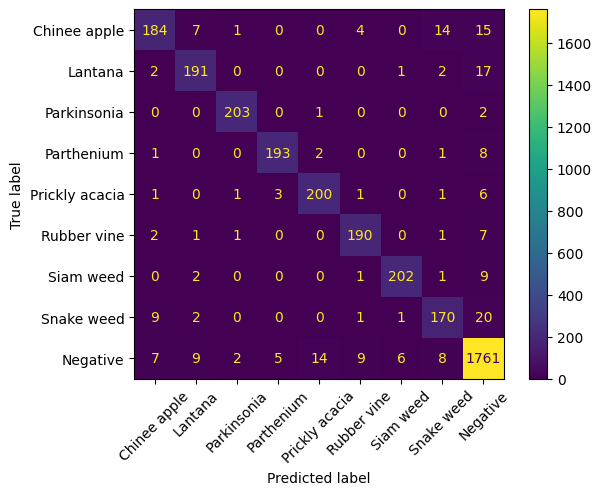


Testn Set Statistics
model.evaluate
110/110 [==============================] - 3s 23ms/step - loss: 0.6676 - accuracy: 0.4820
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.09901   0.04444   0.06135       225
       Lantana    0.09615   0.02358   0.03788       212
   Parkinsonia    0.20000   0.02427   0.04329       206
    Parthenium    0.14286   0.02451   0.04184       204
Prickly acacia    0.29167   0.03302   0.05932       212
   Rubber vine    0.13333   0.02985   0.04878       201
     Siam weed    0.19512   0.03738   0.06275       214
    Snake weed    0.11290   0.03448   0.05283       203
      Negative    0.52457   0.89676   0.66194      1821

      accuracy                        0.48199      3498
     macro avg    0.19951   0.12759   0.11889      3498
  weighted avg    0.34922   0.48199   0.36913      3498


                False Positive Rate  Accuracy
Chinee apple               0.027803  0.044444
Lantana                    0.014303  0.023585
Parkinsonia                0.006075  0.024272
Parthenium                 0.009107  0.024510
Prickly acacia    

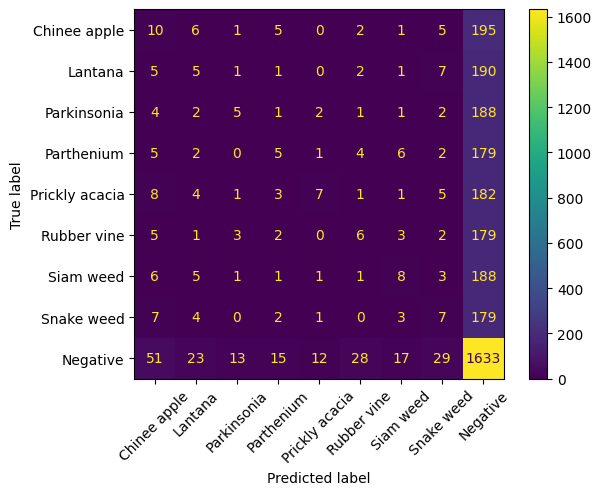

In [23]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

# Freezing Base Model

In [24]:
with strategy.scope():
    for layer in model.layers:
        if 'base' in layer.name.lower():
            print("Freezing layer", layer.name, layer.trainable)
            layer.trainable = False

Freezing layer MobilenetV3small_base_ True


# Evaluations #1.1b

Test After Freezing
Validation Set Stats
model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.0223 - accuracy: 0.9358
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.93367   0.81333   0.86936       225
       Lantana    0.93627   0.89671   0.91607       213
   Parkinsonia    0.97115   0.98058   0.97585       206
    Parthenium    0.93868   0.97073   0.95444       205
Prickly acacia    0.92202   0.94366   0.93271       213
   Rubber vine    0.94924   0.92574   0.93734       202
     Siam weed    0.96667   0.94419   0.95529       215
    Snake weed    0.86190   0.89163   0.87651       203
      Negative    0.95725   0.97144   0.96430      1821

      accuracy                        0.94662      3503
     macro avg    0.93743   0.92645   0.93132      3503
  weighted avg    0.94664   0.94662   0.94625      3503


                False Positive Rate  Accuracy
Chinee apple               0.003966  0.813333
Lantana                    0.003951  0.896714
Parkinsonia                0.001820  0.980583
Parthenium                 0.003942  0.970732
Prickly acacia    

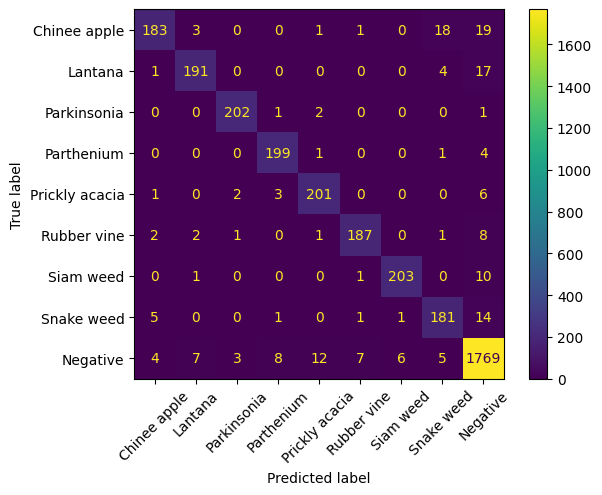

Test Set Stats
model.evaluate
110/110 [==============================] - 3s 22ms/step - loss: 0.6676 - accuracy: 0.4820
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87129   0.78222   0.82436       225
       Lantana    0.96059   0.91981   0.93976       212
   Parkinsonia    0.94811   0.97573   0.96172       206
    Parthenium    0.97409   0.92157   0.94710       204
Prickly acacia    0.92694   0.95755   0.94200       212
   Rubber vine    0.96373   0.92537   0.94416       201
     Siam weed    0.95413   0.97196   0.96296       214
    Snake weed    0.86730   0.90148   0.88406       203
      Negative    0.96048   0.97419   0.96728      1821

      accuracy                        0.94740      3498
     macro avg    0.93630   0.92554   0.93038      3498
  weighted avg    0.94717   0.94740   0.94696      3498


                False Positive Rate  Accuracy
Chinee apple               0.007944  0.782222
Lantana                    0.002435  0.919811
Parkinsonia                0.003341  0.975728
Parthenium                 0.001518  0.921569
Prickly acacia    

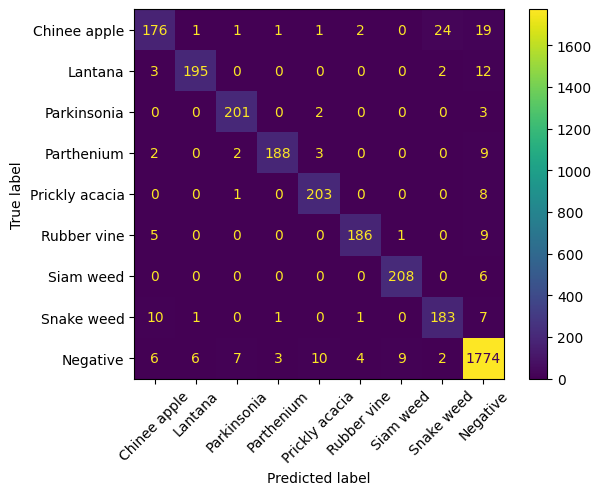

In [25]:
## Test After Freezing
print("Test After Freezing")
print("Validation Set Stats")        
a, b = eval_model(model, validation_generator)

print("Test Set Stats")   
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81696   0.81333   0.81514       225
       Lantana    0.87446   0.95283   0.91196       212
   Parkinsonia    0.94811   0.97573   0.96172       206
    Parthenium    0.97409   0.92157   0.94710       204
Prickly acacia    0.86475   0.99528   0.92544       212
   Rubber vine    0.96373   0.92537   0.94416       201
     Siam weed    0.95413   0.97196   0.96296       214
    Snake weed    0.86730   0.90148   0.88406       203
      Negative    0.97460   0.94838   0.96131      1821

      accuracy                        0.94025      3498
     macro avg    0.91535   0.93399   0.92376      3498
  weighted avg    0.94204   0.94025   0.94057      3498


                False Positive Rate  Accuracy
Chinee apple               0.012527  0.813333
Lantana                    0.008825  0.952830
Parkinsonia                0.003341  0.975728
Parthenium                 0.001518  0.921569
Prickly acacia    

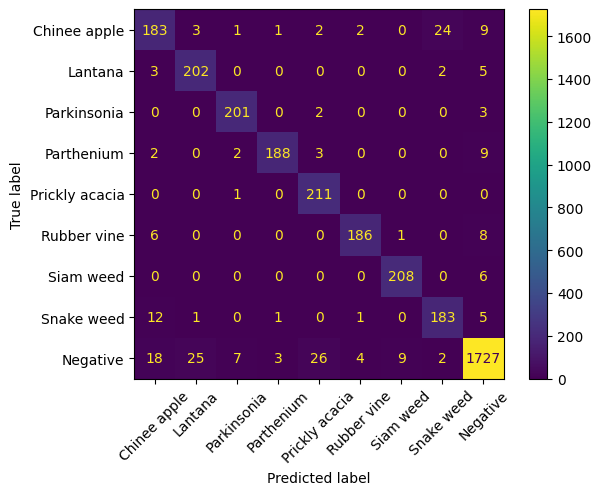

In [26]:
printStats(a,b,0.11)

# Trial 2

In [27]:
with strategy.scope():
    loss = tf.keras.losses.CategoricalFocalCrossentropy()
    optimizer = Adam(learning_rate=INIT_LR2,  weight_decay=W_DECAY2, clipnorm=2.0) if not USE_ADAMW else AdamW(learning_rate=INIT_LR2,  weight_decay=W_DECAY2)
    
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=ES_MONITOR, factor=LR_REDUCTION_FACTOR, patience=ES_PATIENCE, verbose=1, min_lr=MIN_LR2)


print(model.optimizer.get_config())

{'name': 'AdamW', 'weight_decay': 0.0005, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 2e-06, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


Epoch 1/300


2025-06-28 03:18:31.574848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


329/329 [==============================] - 16s 37ms/step - loss: 0.0148 - accuracy: 0.9498 - val_loss: 0.0194 - val_accuracy: 0.9469 - lr: 2.0000e-06
Epoch 2/300
329/329 [==============================] - 11s 33ms/step - loss: 0.0145 - accuracy: 0.9501 - val_loss: 0.0192 - val_accuracy: 0.9489 - lr: 2.0000e-06
Epoch 3/300
329/329 [==============================] - 11s 34ms/step - loss: 0.0134 - accuracy: 0.9528 - val_loss: 0.0192 - val_accuracy: 0.9478 - lr: 2.0000e-06
Epoch 4/300
329/329 [==============================] - 11s 33ms/step - loss: 0.0143 - accuracy: 0.9510 - val_loss: 0.0191 - val_accuracy: 0.9489 - lr: 2.0000e-06
Epoch 5/300
329/329 [==============================] - 11s 33ms/step - loss: 0.0130 - accuracy: 0.9542 - val_loss: 0.0190 - val_accuracy: 0.9492 - lr: 2.0000e-06
Epoch 6/300
329/329 [==============================] - 11s 34ms/step - loss: 0.0134 - accuracy: 0.9535 - val_loss: 0.0190 - val_accuracy: 0.9492 - lr: 2.0000e-06
Epoch 7/300
329/329 [===================

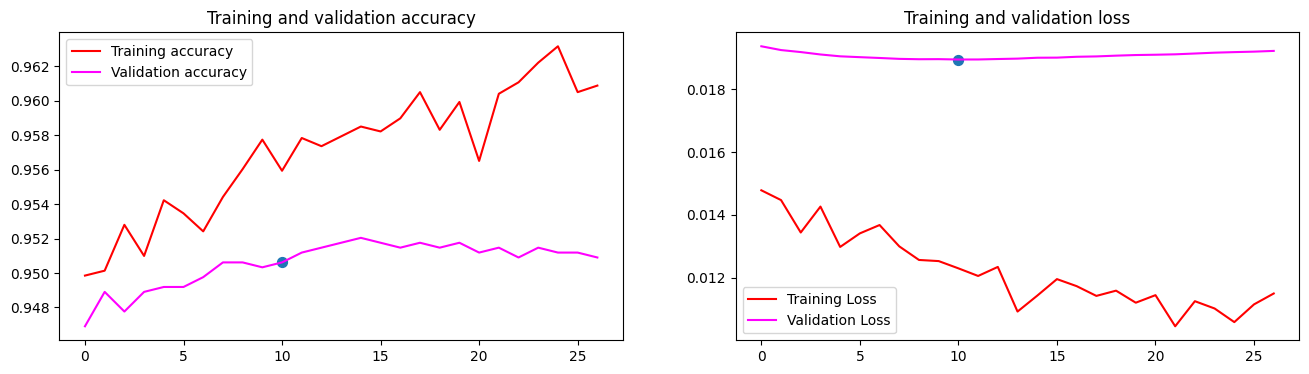

In [28]:
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Checkpoint")
model.save("2-"+MODEL_NAME)

# Plot training results
plot_loss_acc(history2.history)


# Accuracy / Loss Plots

Total Epochs: range(0, 92)


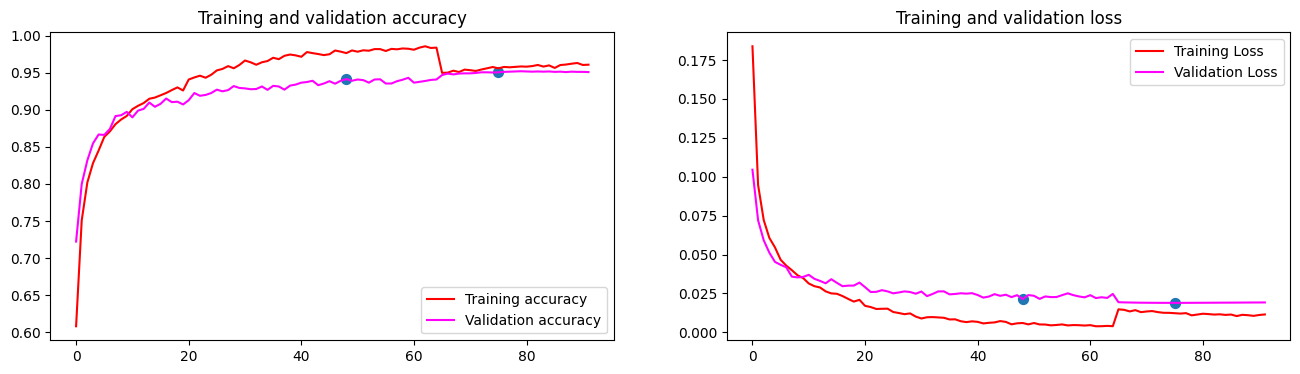

In [29]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es = ES_PATIENCE + 1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 65)


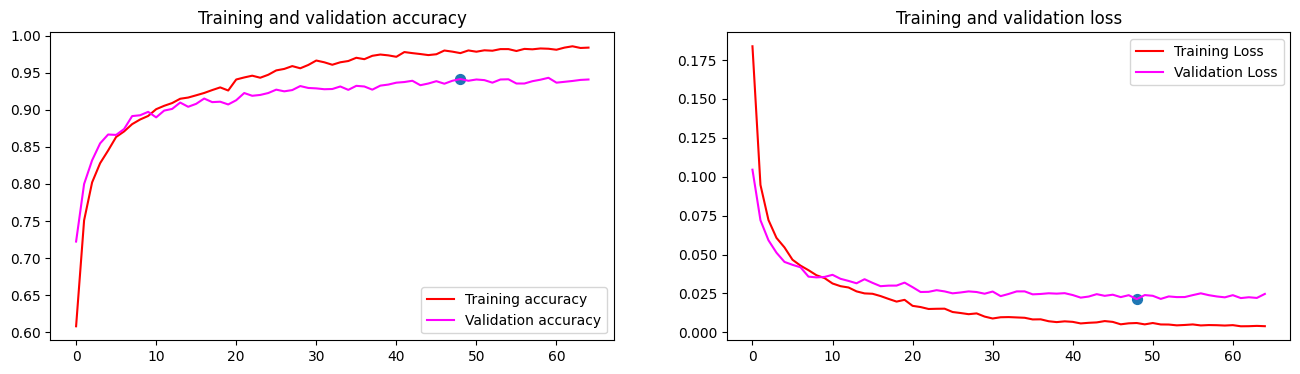

Total Epochs: range(0, 27)


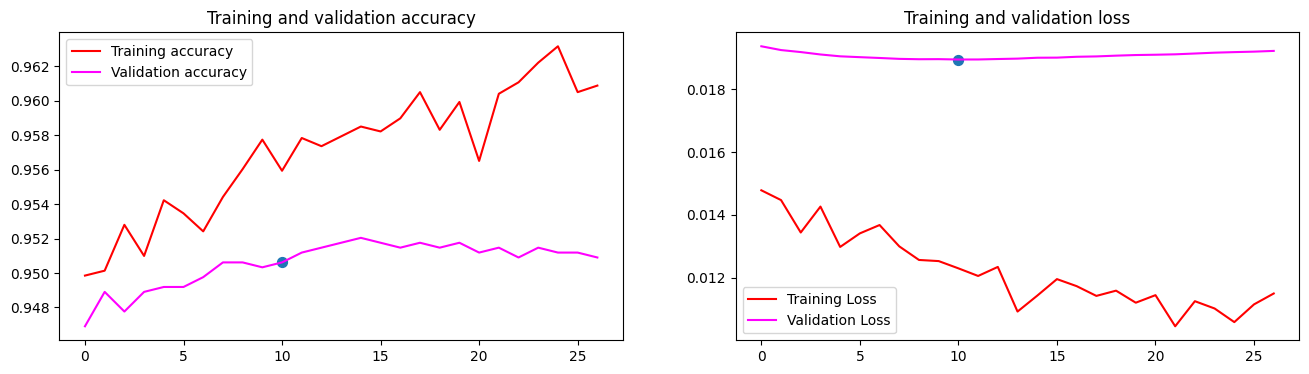

In [30]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

Train Set Statistics
model.evaluate
329/329 [==============================] - 7s 21ms/step - loss: 0.0011 - accuracy: 0.9966
model.predict


  0%|          | 0/329 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.99850   0.98669   0.99256       676
       Lantana    0.99687   0.99843   0.99765       638
   Parkinsonia    0.99676   0.99515   0.99596       619
    Parthenium    0.99511   0.99674   0.99593       613
Prickly acacia    0.98452   0.99843   0.99143       637
   Rubber vine    1.00000   0.99835   0.99917       606
     Siam weed    0.99384   1.00000   0.99691       645
    Snake weed    0.98384   0.99836   0.99105       610
      Negative    0.99927   0.99671   0.99798      5464

      accuracy                        0.99657     10508
     macro avg    0.99430   0.99654   0.99540     10508
  weighted avg    0.99660   0.99657   0.99658     10508


                False Positive Rate  Accuracy
Chinee apple               0.000102  0.986686
Lantana                    0.000203  0.998433
Parkinsonia                0.000202  0.995153
Parthenium                 0.000303  0.996737
Prickly acacia    

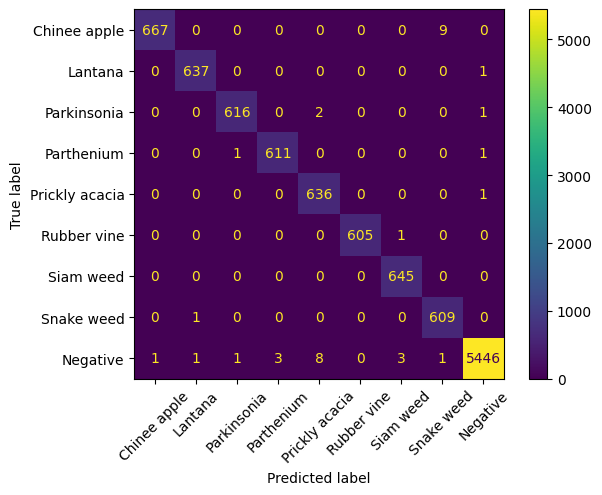


Validation Set Statistics
model.evaluate
110/110 [==============================] - 2s 20ms/step - loss: 0.0189 - accuracy: 0.9506
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.91584   0.82222   0.86651       225
       Lantana    0.92925   0.92488   0.92706       213
   Parkinsonia    0.97115   0.98058   0.97585       206
    Parthenium    0.94286   0.96585   0.95422       205
Prickly acacia    0.91403   0.94836   0.93088       213
   Rubber vine    0.94527   0.94059   0.94293       202
     Siam weed    0.95475   0.98140   0.96789       215
    Snake weed    0.86667   0.89655   0.88136       203
      Negative    0.96975   0.96815   0.96895      1821

      accuracy                        0.95061      3503
     macro avg    0.93440   0.93651   0.93507      3503
  weighted avg    0.95064   0.95061   0.95041      3503


                False Positive Rate  Accuracy
Chinee apple               0.005186  0.822222
Lantana                    0.004559  0.924883
Parkinsonia                0.001820  0.980583
Parthenium                 0.003639  0.965854
Prickly acacia    

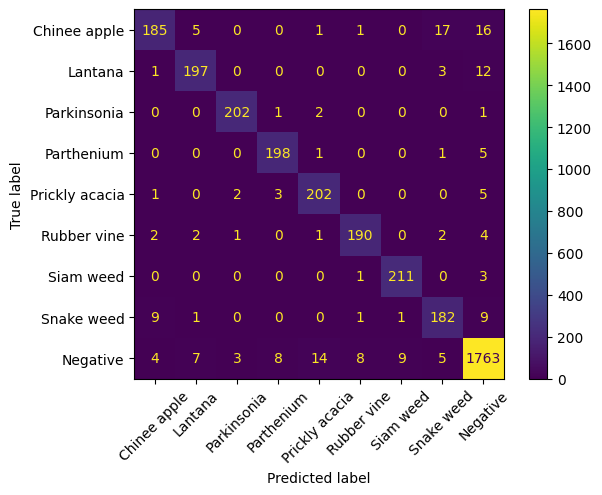


Testn Set Statistics
model.evaluate
110/110 [==============================] - 2s 20ms/step - loss: 0.0202 - accuracy: 0.9443
model.predict


  0%|          | 0/110 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.85990   0.79111   0.82407       225
       Lantana    0.95169   0.92925   0.94033       212
   Parkinsonia    0.95714   0.97573   0.96635       206
    Parthenium    0.97895   0.91176   0.94416       204
Prickly acacia    0.92694   0.95755   0.94200       212
   Rubber vine    0.95385   0.92537   0.93939       201
     Siam weed    0.91304   0.98131   0.94595       214
    Snake weed    0.85047   0.89655   0.87290       203
      Negative    0.96386   0.96650   0.96518      1821

      accuracy                        0.94425      3498
     macro avg    0.92843   0.92613   0.92670      3498
  weighted avg    0.94442   0.94425   0.94402      3498


                False Positive Rate  Accuracy
Chinee apple               0.008860  0.791111
Lantana                    0.003043  0.929245
Parkinsonia                0.002734  0.975728
Parthenium                 0.001214  0.911765
Prickly acacia    

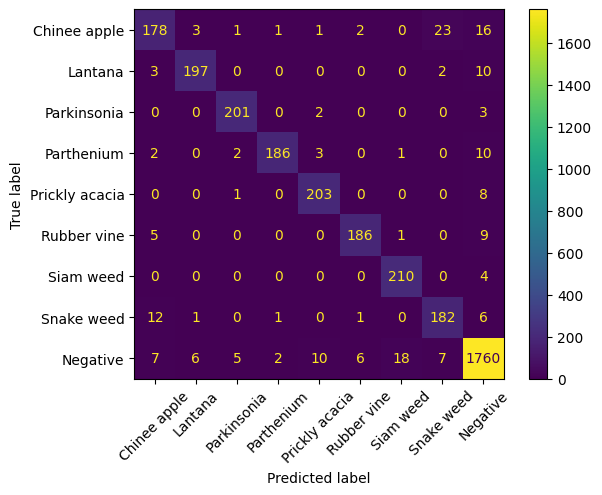

In [31]:
print("Train Set Statistics")
a, b = eval_model(model, train_generator)

print("\nValidation Set Statistics")
a, b = eval_model(model, validation_generator)

print("\nTestn Set Statistics")
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.77966   0.81778   0.79826       225
       Lantana    0.82186   0.95755   0.88453       212
   Parkinsonia    0.95714   0.97573   0.96635       206
    Parthenium    0.97906   0.91667   0.94684       204
Prickly acacia    0.84064   0.99528   0.91145       212
   Rubber vine    0.95337   0.91542   0.93401       201
     Siam weed    0.90517   0.98131   0.94170       214
    Snake weed    0.85047   0.89655   0.87290       203
      Negative    0.97680   0.92477   0.95007      1821

      accuracy                        0.92796      3498
     macro avg    0.89602   0.93123   0.91179      3498
  weighted avg    0.93239   0.92796   0.92885      3498


                False Positive Rate  Accuracy
Chinee apple               0.015888  0.817778
Lantana                    0.013390  0.957547
Parkinsonia                0.002734  0.975728
Parthenium                 0.001214  0.916667
Prickly acacia    

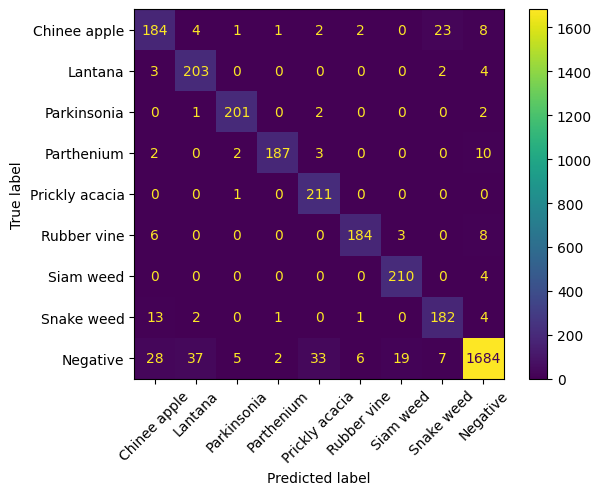

In [32]:
printStats(a,b,0.11)

## Clear Files

In [33]:
shutil.rmtree(base_dir)